# Analyze the tree-guided MTL results on the iPCs data produced by Kathrin

The purpose of this analysis is to study the role of transcription factors (TFs) in deriving the gene expession in single cells of two annotated cell types: HLC and PHH. We expect the statistical model to select distinct sets of TFs for each cell type.

## Data
The data to be used for training the tree-guided MTL model:

### Features
We defined two types of features representing different regions of the genome: Promoter, Enhancer (regulatrory regions). The binding affinity of ~700 TFs are estimated in these two region types for each gene.

### Responses
The response **matrix** here is essentially the gene expression matrix for the iPCs cells.

## Filtering
### Based on gene expression variance
The genes showing small variance in their expression across the single cells are removed from the data.
### Based on TF expression
The TFs that their corresponding genes are not expressed in more than 90% of the cells are removed as well.

## Model fitting
* Partitioned 60% of the data for training and 40% for test
* Data is normalized with zero mean and unit variance
* 5-fold CV is used to select the model with best average CV error.
* 21 lambda values are explored during the CV prodecure.
* Maximum number of iterations is limitted to 200

The fitted model together with the partitioned data are stored in an RData object that can be loaded.

## Load the model

In [2]:
load("../scMTL_StemNet_TPM_TGGLasso_hc_Roadmap_Promoter_weights_corrected_max_iter_200.RData")

## Normalize the partitioned data
The stored partitioned data in the above RData object is in the original space. In order to proceed with the downstream analysis, it's easier to normalize them in the same way they were done before model fitting.

In [2]:
x.train <- scale(partition$train$x)
y.train <- scale(partition$train$y)


x.test <- scale(partition$test$x, center= colMeans(partition$train$x), scale= apply(partition$train$x, 2, 
FUN= sd))
y.test <- scale(partition$test$y, center= colMeans(partition$train$y), scale= apply(partition$train$y, 2, 
FUN= sd))

## Train and test dimenstion

In [3]:
print("train:")
print(dim(x.train))
print("test:")
print(dim(x.test))

[1] "train:"
[1] 1006 1429
[1] "test:"
[1]  671 1429


## Cell names

In [18]:
head(colnames(y.train))

[1] "HLC_CEL_c1_R1"  "HLC_CEL_c10_R1" "HLC_CEL_c11_R1" "HLC_CEL_c13_R1"
[5] "HLC_CEL_c14_R1" "HLC_CEL_c15_R1"

## PCA applied on training and test features
Unfortunately this part does not work for this dataset, since we have more features than samples (more TFs than genes)

In [4]:
doPCA <- FALSE
if(doPCA){
    pca.train <- princomp(x.train)
    pca.test <- princomp(x.test)
    par(mfrow= c(1, 2))
    plot(pca.train)
    plot(pca.test)
}

## Compute the predictions on training and test data

In [5]:
pred.train <- cbind(1, x.train) %*% rbind(TGL.model$intercept, TGL.model$B)
pred.test <- cbind(1, x.test) %*% rbind(TGL.model$intercept, TGL.model$B)

### Plot the scatter plots for some random cells (training data)

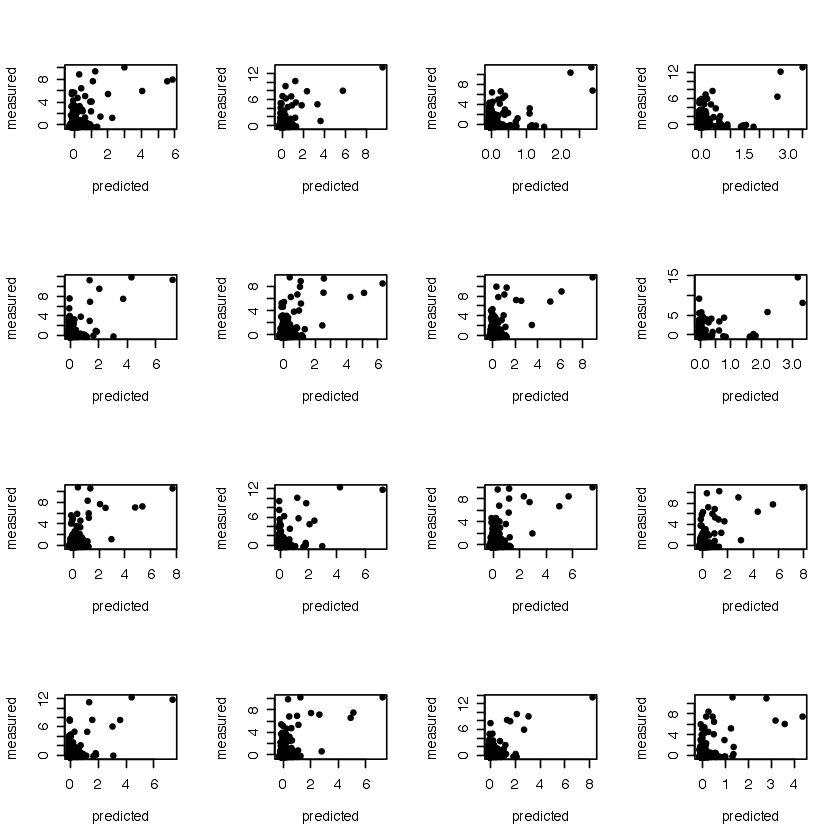

In [11]:
n <- 16
par(mfrow = c(sqrt(n), sqrt(n)))

random.idx <- sample(ncol(pred.train))[seq(n)]
for(i in seq(n))
    plot(pred.train[, random.idx[i]], y.train[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

### Plot the scatter plots for some random cells (test data)

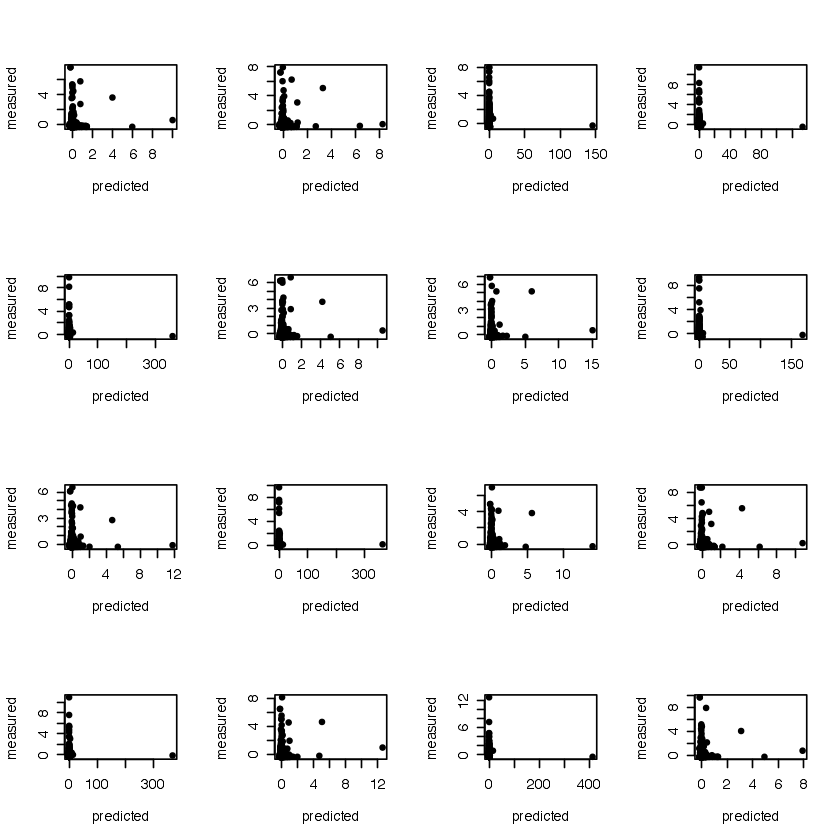

In [12]:
#n <- 25
par(mfrow = c(sqrt(n), sqrt(n)))

#random.idx <- sample(ncol(pred.test))[seq(n)]
for(i in seq(n))
    plot(pred.test[, random.idx[i]], y.test[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

## Compute the correlations between predicted and actual measurements of gene expression

In [15]:
# Train
## Method= Pearson
cors.train.p <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "pearson"))

## Method= Spearman
cors.train.s <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "spearman"))
                      
# Test
## Method= Pearson
cors.test.p <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "pearson"))

## Method= Spearman
cors.test.s <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "spearman"))

Warning message in cor(pred.train[, i], y.train[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.train[, i], y.train[, i], method = "spearman"):
“the standard deviation is zero”Warning message in cor(pred.test[, i], y.test[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.test[, i], y.test[, i], method = "spearman"):
“the standard deviation is zero”

## Plot the prediction correlations for each cell colored according to the cell type

In [21]:
cell.types <- sapply(seq(ncol(y.train)), function(i) strsplit(colnames(y.train)[i], "_")[[1]][1])
print(range(cell.types))

[1] "HLC" "PHH"


### HLC: red, PHH: blue

In [22]:
cols <- rep("red", ncol(y.train))
cols[which(cell.types == "PHH")] <- "blue"

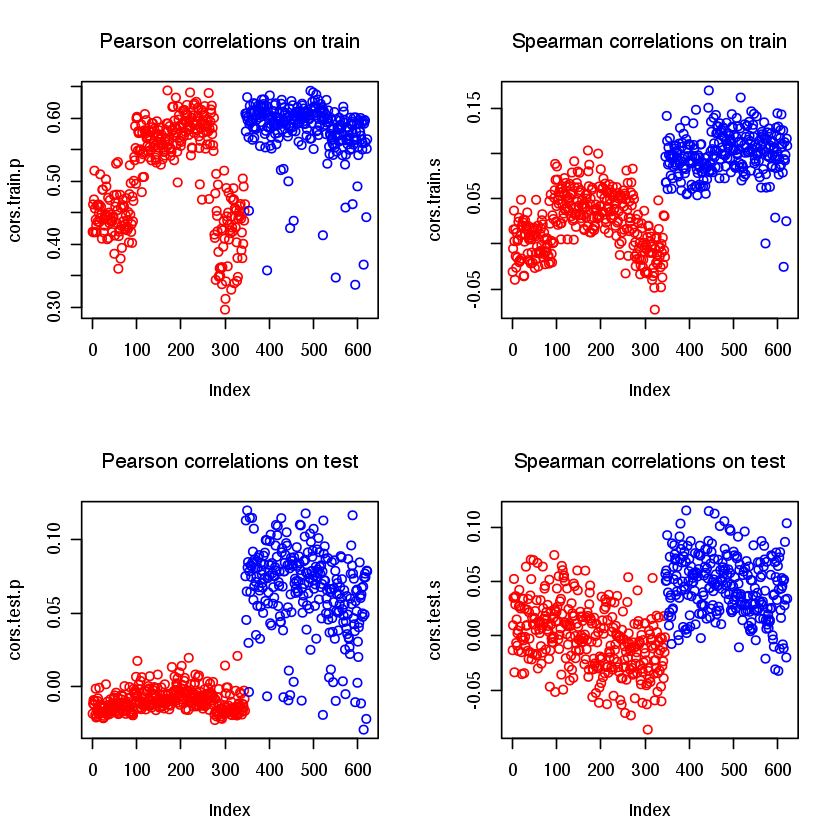

In [23]:
par(mfrow = c(2, 2))

plot(cors.train.p, main= "Pearson correlations on train", col= cols)
plot(cors.train.s, main= "Spearman correlations on train", col= cols)
plot(cors.test.p, main= "Pearson correlations on test", col= cols)
plot(cors.test.s, main= "Spearman correlations on test", col= cols)

# Conclusion of the correlatoin analysis
* The model performance measured in terms of correlation suggests a great amount of over-training. This is most likely due to the small samples size problem (1429 TFs and 1006 genes). To check for this affect, I already started running the model where the promoter features are used only. This shrinks the feature space to half (715 TFs). The results aren't done yet. I'll update this notebook later when they're ready...
* The current results already indicate a clear distiction in terms of performance between the two cell types. This makes it worthwhile to look at the model coefficients.

## Plot the coefficients obtained from the model

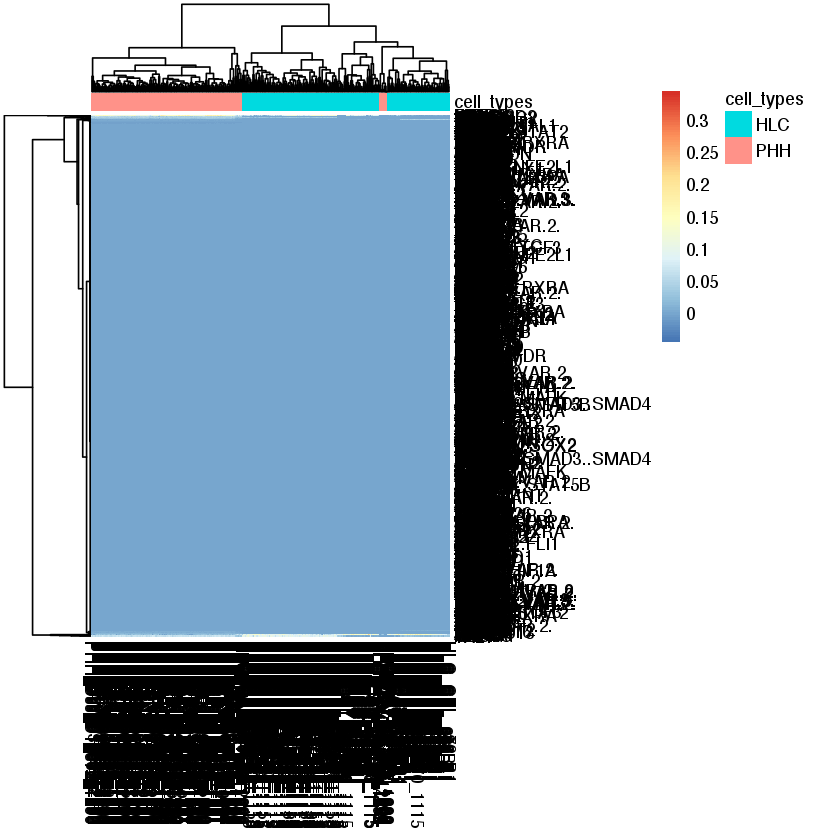

In [24]:
## Load the pheatmap library
library(pheatmap)

## Make the column annotation dataframe for the pheatmap function
ann_col <- data.frame(cell_types= cell.types)
rownames(ann_col) <- colnames(y.train)
colnames(TGL.model$B) <- colnames(y.train)
pheatmap(TGL.model$B, annotation_col= ann_col)

As there are quite a lot of the small-valued coefficients in the heatmap, it makes sense to plot only the few with higher values.

In [25]:
top_TFs <- which(rowSums(abs(TGL.model$B)) > .1)
length(top_TFs)

[1] 45

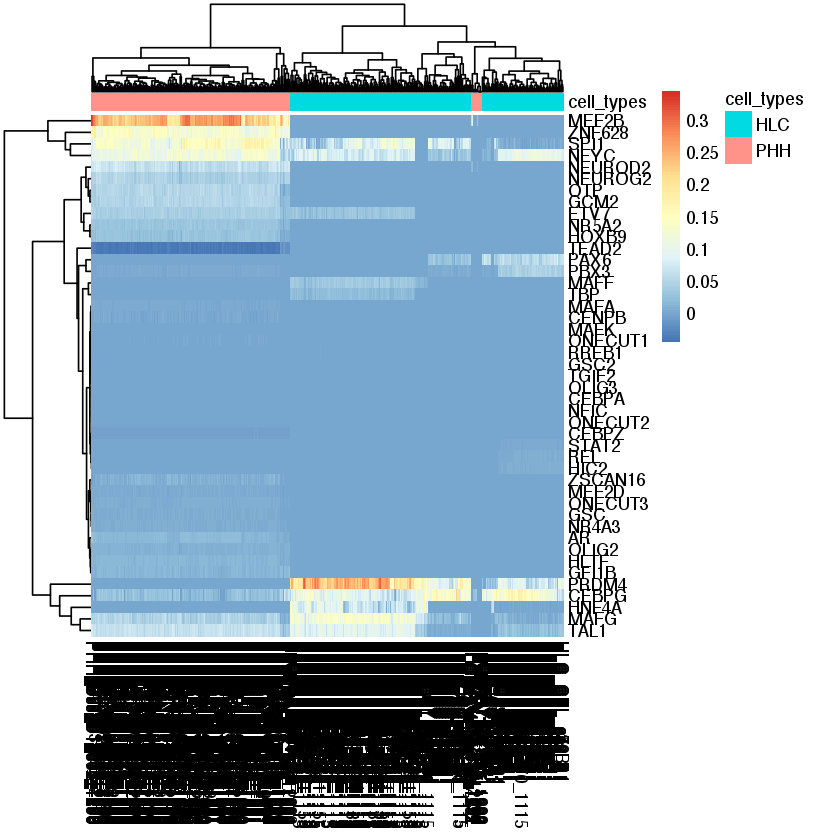

In [26]:
pheatmap(TGL.model$B[top_TFs, ], annotation_col= ann_col)

There is a clear distiction in the coefficients of the TFs assigned for each cell type. If the model's performance was better, one could've considered this as a very exciting results with some biological significance. But, as long as the performance is so low (on test), I'll refrain to draw any strong conclusoins on the shown results. This for sure requires further improvements...

## Future work
* Look at the results where only the promoter features are used
* Impute the expression data to see if that helps the prediction

# New results where only promoter features are used

In [3]:
## Load the model

load("../scMTL_StemNet_TPM_TGGLasso_hc_real_weights_corrected_max_iter_200.RData")

## Normalize the partitioned data

x.train <- scale(partition$train$x)
y.train <- scale(partition$train$y)


x.test <- scale(partition$test$x, center= colMeans(partition$train$x), scale= apply(partition$train$x, 2, 
FUN= sd))
y.test <- scale(partition$test$y, center= colMeans(partition$train$y), scale= apply(partition$train$y, 2, 
FUN= sd))

## Train and test dimenstion

print("train:")
print(dim(x.train))
print("test:")
print(dim(x.test))

[1] "train:"
[1] 8547  726
[1] "test:"
[1] 5699  726
